# Tutorial 4: Diffusivities and morphological ages

There is no standardized way to calculate diffusivity ($k$) estimates from diffusion ages. A skim of the literature will reveal a plethora of possibilites, but riserfit uses an approach loosely based on [Wei et al. 2015](https://doi.org/10.1016/j.jseaes.2015.02.016).
1) $kt$ estimates from the same terrace generation are combined into a kernel density estimate (KDE) where each kernel is a triangular PDF bound by the uncertainty bounds calculated in Tutorial 2 and 3. This is actually more similar to a "Probability Density Plot" used in detrital thermochronology (e.g. [Vermees 2012](https://doi.org/10.1016/j.chemgeo.2012.04.021)).
2) An external age constraint on at least one of the terraces is needed to infer diffusivities. This constraint can be a single or multiple age(s) with associated uncertainties.
3) A $k$ KDE/PDF estimate is generated by sampling from the $kt$ and external age distributions.
4) The generated $k$ PDF can then be used on the same or other terraces.

In riserfit, this process is mostly handled by the `rf.StatsMC` class. It has functions to create the $kt$ KDE (`rf.StatsMC.construct_kt_kde()`), an external age KDE (`rf.StatsMC.construct_initial_t_kde()`), the diffusivity KDE (`rf.StatsMC.construct_MC_k_kde()`), and the morphological age distribution (`rf.StatsMC.construct_MC_t_kde()`).

First, we need to load our Riser instances and add an independent age constraint. We will just assume that we have two CRN exposure ages from the younger terrace (T7): $t_1 = 2.19 \pm 0.2~\text{kyr}$ and $t_2 = 2.4 \pm 0.3~\text{kyr}$

In [1]:
# Some imports
import riserfit as rf
import os
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [2]:
# load the risers from the last notebook
os.chdir(r"C:\\Users\\Lennart\\lennartGit\\personal\\riserfit\\Tutorials")

# load the two riser instances
terraces = ["T7", "T3"]
fnames = [f"\\Data\\Risers\\Instances\\{t}_Riser_instance.gz" for t in terraces]
risersT7 = rf.load_instance(fnames[0])
risersT3 = rf.load_instance(fnames[1])

# as with everything else in riserfit, we need to provide an age estimate for every single riser. 
# This age estimate can consist of multiple ages!
t = [np.array([2.19, 2.4]) for _ in risersT7.name] # one entry for each profile, each entry has both ages.
t_sigma = [np.array([0.2, 0.3]) for _ in risersT7.name]
# add the age information
risersT7.add_parameter("t", t)
risersT7.add_parameter("t_sigma", t_sigma)

# create the StatsMC instance
statsT7 = risersT7.construct_StatsMC_instance(
    kt_parameter_name="nonlin_best_t", # this is a young terrace, so let's use the nonlinear diffusion ages
    kt_lb_parameter_name="nonlin_lower_t",
    kt_ub_parameter_name="nonlin_upper_t",
    t_parameter_name="t",
    t_sigma_parameter_name="t_sigma"
)

# The return is actually a tuple with just one entry. There is a good reason for this: 
# If our riser instance contains profiles from different terrace generations, the profiles are automatically separated into groups
# with equal external age constraints (the "t" parameter). In this case, we just have one return, because all profiles are from the same terrace.
print(statsT7)
statsT7 = statsT7[0]

(<riserfit.riser_maths.StatsMC object at 0x000001C6D293F760>,)


Next, we walk through the steps described above.

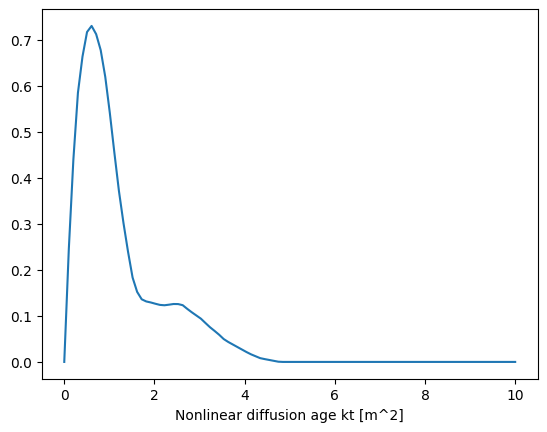

[0.57001 3.19001 0.74001]
[0.50012813 0.85571221 1.48539692]


In [3]:
# 1) Construct a kt distribution
statsT7.construct_kt_kde(
    max_val=100, # the upper bound of our kde
    kt_resolution=0.05
);

# what does it look like?
x = np.linspace(0, 10, 100)
y = statsT7.kt_kde.pdf(x)
plt.plot(x, y)
plt.xlabel("Nonlinear diffusion age kt [m^2]")
plt.show()

# What is kt_kde? It is another internal class of riserfit, this time
# rf.DistributionFromInterpolator. It creates a PDF from a set of x and y
# values that describe the values of a PDF.
print(statsT7.kt_kde)

# There are some useful functions here, like creating a sample of kt
print(statsT7.kt_kde.sample(resolution=0.01, n=3))
# or inferring the median (and other quantiles) from the inverse CDF
print(statsT7.kt_kde.inverse_cdf(np.array([0.25, 0.5, 0.75])))

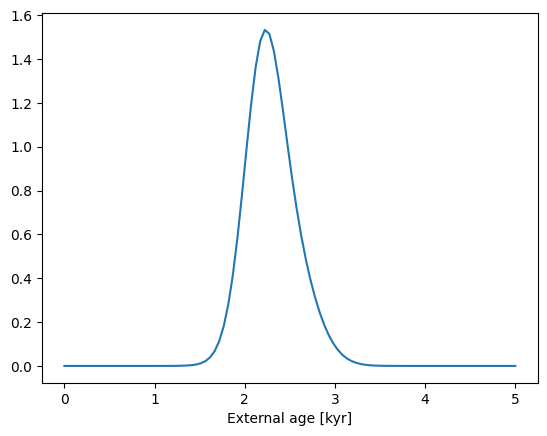

In [4]:
# 2) Create a PDF of the external age constraints
statsT7.construct_initial_t_kde(
    t_resolution=0.05
);

# What does it look like?
x = np.linspace(0, 5, 100)
y = statsT7.initial_t_kde.pdf(x)
plt.plot(x, y)
plt.xlabel("External age [kyr]")
plt.show()

That took 1.29 seconds!


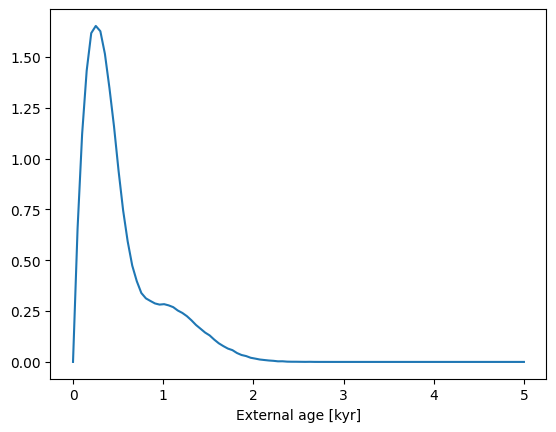

median k = 0.387 m^2/kyr
This is very close to the distribution median: 0.381 m^2/kyr!


In [5]:
# 3) Create a PDF of k, inferred by dividing many draws of kt by draws of t
start = time()
statsT7.construct_MC_k_kde(
    n=1_000_000, # number of draws
    max_val=10,
    k_resolution=0.01 # higher resolution necessitates more draws!
);
end = time()
print(f"That took {end-start:.2f} seconds!")

# What does it look like?
x = np.linspace(0, 5, 100)
y = statsT7.k_kde.pdf(x)
plt.plot(x, y)
plt.xlabel("External age [kyr]")
plt.show()

# what is the median k estimate?
print(f"median k = {np.median(statsT7.k_sample):.3f} m^2/kyr")
print(f"This is very close to the distribution median: {statsT7.k_kde.inverse_cdf(0.5):.3f} m^2/kyr!")

That took 0.97 seconds!


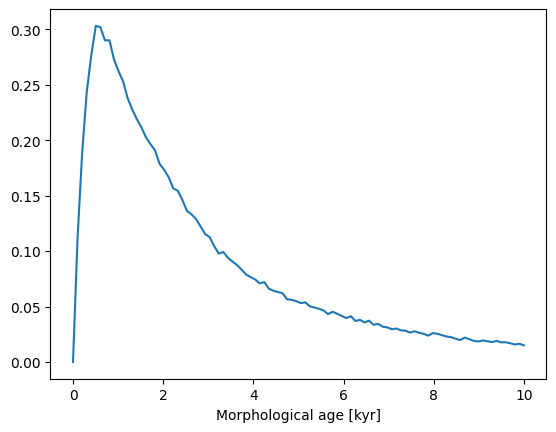

Morphological age: 2.257 kyr
External age: 2.249 kyr


In [6]:
# 4) Finally, we can infer the morphological age
start = time()
statsT7.construct_MC_t_kde(
    max_val=50,
    n=1_000_000,
    t_resolution=0.01
)
end = time()
print(f"That took {end-start:.2f} seconds!")

# What does it look like?
x = np.linspace(0, 10, 100)
y = statsT7.MC_t_kde.pdf(x)
plt.plot(x, y)
plt.xlabel("Morphological age [kyr]")
plt.show()

# Let's compare the morphological age to the external age...
print(f"Morphological age: {statsT7.MC_t_kde.inverse_cdf(0.5):.3f} kyr")
print(f"External age: {statsT7.initial_t_kde.inverse_cdf(0.5):.3f} kyr")
# Unsurprisingly, they are identical. But that is because we use the PDF of k,
# which we have calibrated using the external age, to calculate the age again.

### Applying diffusivities to other terraces
The example above shows that it works! We got a morphological age estimate that matches the external age constraint! There are some caveats: First, it is not really surprising that the morphological age agrees with the external age. After all, we have used the external age to calibrate the $k$ PDF... Second, why should we be interested in the morphological age of a terrace that already has quite a robust age?

Our efforts where not in vain, however! After all, constraining the diffusivity itself is interesting. It is a parameter common to many landscape evolution models. Also, we can now apply this estimate of $k$ to other, undated terraces! As a last exercise, we can apply our $k$ PDF to the risers of T3.

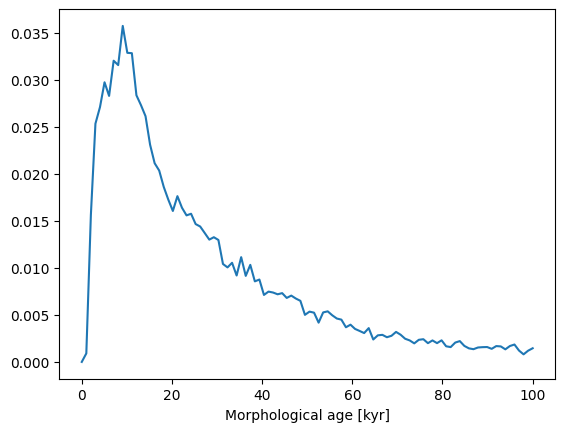

Our estimate for morphological age is: 20.82 kyr


In [13]:
# First, we need to generate a StatsMC instance from risersT3. This time, we do not know t
t = [np.nan for _ in risersT3.name]
t_sigma = t
risersT3.add_parameter("t", t)
risersT3.add_parameter("t_sigma", t_sigma)

# create the StatsMC instance
statsT3 = risersT3.construct_StatsMC_instance(
    kt_parameter_name="nonlin_best_t", # this is a young terrace, so let's use the nonlinear diffusion ages
    kt_lb_parameter_name="nonlin_lower_t",
    kt_ub_parameter_name="nonlin_upper_t",
    t_parameter_name="t",
    t_sigma_parameter_name="t_sigma"
)[0] # select the first and only StatsMC from the tuple

# generate the kt KDE
statsT3.construct_kt_kde(
    max_val=20,
    kt_resolution=0.01
)

# now, add the k KDE from the T3 instance
statsT3.set_k_kde(statsT7.k_kde)

# and calculate a morphological age
statsT3.construct_MC_t_kde(
    max_val=500,
    n=1_000_000,
    t_resolution=0.01
)

# What does it look like?
x = np.linspace(0, 100, 100)
y = statsT3.MC_t_kde.pdf(x)
plt.plot(x, y)
plt.xlabel("Morphological age [kyr]")
plt.show()

print(f"Our estimate for morphological age is: {statsT3.MC_t_kde.inverse_cdf(0.5):.2f} kyr")

### Saving StatsMC instances
Just like with Riser instances, we can save the StatsMC instances and load them again. This avoids having to re-calculate all the KDEs and PDFs every time. Saving works the same way as with Riser instances...

In [17]:
statsT3.save_instance(r"\\Data\\Risers\\Instances\\");
statsT7.save_instance(r"\\Data\\Risers\\Instances\\");